## Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import pickle
import math
import io
import requests

# webscraping
import requests
from bs4 import BeautifulSoup

# stocks
import yfinance as yf

# fama french
import statsmodels.api as sm
from statsmodels import regression
from scipy.optimize import minimize
from scipy.linalg import eigh
from scipy.fft import fft

# markowitz
from sklearn.decomposition import PCA
from TracyWidom import TracyWidom
import cvxopt as opt
from cvxopt import blas, solvers
import cufflinks
import mplfinance as mpf
import plotly.tools as tls
from plotly.graph_objs import *
solvers.options['show_progress'] = False
import rie_estimator

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import sys
# !{sys.executable} -m pip install rie_estimator

## Basic Goal

Plan: 
1. Data gathering
      - Randomly select 30 stocks from the S&P 500 
      - Get data for each of the stocks from the past 3 years using yfinance.  
      - Get the daily Fama-French factors from the Kenneth French website.
2. Implement the PCA Markowitz portfolio optimization
      - PCA on normalized returns
      - Check if PC1 is significant using Tracy-Widow
      - Get the portfolio that corresponds to PC1
3. Implement the Fama-French three-factor model
      - For each stock, run the standard time series regression for the Fama-French model. 
      - Get the covariance matrix from the residuals 
4. Compare the 2 portfolios against the efficient frontier

### Data Gathering

In [3]:
# getting the stocks
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    )
}

response = requests.get(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    headers=headers
)
response.raise_for_status()
tables = pd.read_html(response.text)

if len(tables) > 0:
    stocks_df = tables[0]

# randomly selecting 30 stocks
random_stocks = stocks_df['Symbol'].sample(n=30, random_state=42)

In [4]:
# getting closing prices for the 30 stocks with batching
start_date = '2022-08-31'
end_date = '2025-08-31'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                # Handle single ticker case (returns Series instead of DataFrame)
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay between batches to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    # Combine all data into a single DataFrame
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     random_stocks.tolist(), 
#     batch_size=5, 
#     delay=15
# )

This code above was generated with ChatGPT.

In [5]:
# if not closing_df.empty:
#     closing_df.to_pickle('closing prices.pkl')

# closing_df.head(5)

In [6]:
# opening pkl file
filename = r'closing prices.pkl'
with open(filename, 'rb') as f: 
    closing_df = pickle.load(f)
    closing_df.index = pd.to_datetime(closing_df.index)

# getting s&p 500 data
filename = r'gspc prices.pkl'
with open(filename, 'rb') as f: 
    gspc_df = pickle.load(f)
    gspc_df.index = pd.to_datetime(gspc_df.index)
gspc_df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

# getting simple returns
simple_df = closing_df / closing_df.shift()
simple_df.dropna(how='all', inplace=True)

# getting log returns
log_df = np.log(simple_df)

C:\Users\Donna\AppData\Local\Temp\ipykernel_30880\1399196482.py:4: DeprecationWarning:

numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.



In [7]:
# getting fama french factors
ff_data = pd.read_csv(
    'ff_factors.csv', 
    header=3
)
ff_data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
ff_data = ff_data.iloc[:-1]

# getting dates
ff_data['date'] = ff_data['date'].astype(str).str.strip()

for idx in range(len(ff_data['date'])):
    date = ff_data.iloc[idx, 0]
    ff_data.iloc[idx, 0] = date[:4] + '-' + date[-4:-2] + '-' + date[-2:]

ff_data['date'] = pd.to_datetime(ff_data['date'])
ff_data.set_index('date', inplace=True)
ff_data = ff_data.loc[start_date:end_date]
ff_data = ff_data.iloc[1:, :]
ff_data = ff_data.apply(pd.to_numeric, errors='coerce')
ff_data

,Mkt-RF,SMB,HML,RF
date,,,,
2022-09-01,0.00,-1.11,-0.28,0.01
2022-09-02,-0.99,-0.06,1.03,0.01
2022-09-06,-0.51,-0.45,-0.54,0.01
2022-09-07,1.92,0.71,-1.53,0.01
2022-09-08,0.78,-0.08,-0.18,0.01
...,...,...,...,...
2025-08-25,-0.48,-0.63,0.45,0.02
2025-08-26,0.43,0.25,0.13,0.02
2025-08-27,0.24,0.40,0.27,0.02


### PCA Markowitz portfolio optimization
Donna's version; Paolo's old version should be in the git history :>

In [8]:
def get_portfolio(closing_df, year):  # Added year parameter
    returns_df = closing_df.pct_change().dropna()
    centered_returns = returns_df - returns_df.mean()

    # apply pca to returns, not prices
    pca = PCA(n_components=2)
    pca.fit(centered_returns)

    # Get portfolio weights from PCA components
    portfolio_weights = pd.DataFrame(
        pca.components_.T,
        index=returns_df.columns,
        columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
    )

    # normalize weights
    for col in portfolio_weights.columns:
        portfolio_weights[col] = portfolio_weights[col] / portfolio_weights[col].sum()
    
    # get portfolios
    mp = portfolio_weights["PC1"]
    other_portfolios = portfolio_weights.iloc[:, 1:]
        
    return mp, other_portfolios

def get_sharpe(rx, stdev, start_date, end_date):
    # risk free rates important
    rf_annual = ff_data.loc[start_date:end_date, 'RF'].mean() / 100
    rf_daily = rf_annual / 252

    # sharpe stuff
    excess_return = rx - rf_daily
    sharpe_daily = excess_return / stdev if stdev > 1e-10 else 0
    sharpe_annual = sharpe_daily * np.sqrt(252)
    
    return sharpe_annual

def plot_portfolios(portfolios, start_date, end_date, max_risk=0.3):
    raw_returns = closing_df.loc[start_date:end_date].pct_change().dropna()
    gspc_returns = gspc_df.loc[start_date:end_date].pct_change().dropna()
    
    # creating mean returns and covariance
    mean_returns = raw_returns.mean()
    cov_matrix = raw_returns.cov()
    n_assets = len(mean_returns)

    # plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # generate random portfolios
    raw_weights = np.random.randn(100000, n_assets)
    weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)
    returns = weights @ mean_returns.values

    # portfolio variances and standard deviations
    portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
    risks = np.sqrt(portfolio_vars)
    
    # filter by max risk if specified
    if max_risk is not None:
        mask = risks <= max_risk
        filtered_returns = returns[mask]
        filtered_risks = risks[mask]
    else:
        filtered_returns = returns
        filtered_risks = risks

    # getting sharpe ratio
    rf_annual = ff_data.loc[start_date:end_date, 'RF'].mean() / 100
    rf_daily = rf_annual / 252
    sharpe_ratio_random = (filtered_returns - rf_daily) / filtered_risks
    
    # plot random portfolios
    sc = ax.scatter(filtered_risks, filtered_returns, c=filtered_returns/filtered_risks,
                    cmap='viridis', s=10, alpha=0.5, label='Random Portfolios')
    plt.colorbar(sc, ax=ax, label='Sharpe Ratio (Return/Risk)')

    # plot gspc portfolio
    df = gspc_df.loc[start_date:end_date].pct_change().dropna()
    rf_daily = (ff_data.loc[df.index, 'RF'] / 100 / len(df.index))
    excess_returns = df['GSPC'] - rf_daily.values
    gspc_sharpe = (excess_returns.mean() / excess_returns.std()) * np.sqrt(len(df.index))
    
    gspc_return = excess_returns.mean()
    gspc_risk = excess_returns.std()
    
    gspc_sharpe = get_sharpe(gspc_return, gspc_risk, start_date, end_date)
    ax.scatter(gspc_risk, gspc_return, color='blue', s=100, edgecolors='black', zorder=5, label='S&P 500')
    ax.text(gspc_risk, gspc_return, f'S&P 500', 
            fontsize=9, ha='left', va='bottom')
    
    # plot portfolios
    for i, portfolio in enumerate(portfolios):
        # Get portfolio weights aligned with current assets
        portfolio_weights = portfolio.reindex(mean_returns.index).fillna(0).values
        
        # Calculate portfolio return and risk
        portfolio_return = np.dot(portfolio_weights, mean_returns.values)
        portfolio_risk = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix.values, portfolio_weights)))
        portfolio_sharpe = get_sharpe(portfolio_return, portfolio_risk, start_date, end_date)
        
        # Plot the portfolio
        label = portfolio.name if hasattr(portfolio, 'name') else f'Portfolio {i+1}'
        ax.scatter(portfolio_risk, portfolio_return, color='red', s=100, edgecolors='black', zorder=5)
        ax.text(portfolio_risk, portfolio_return, f'{label}', 
                fontsize=9, ha='left', va='bottom')

    ax.set_title(f'Period {str(start_date).split()[0]} to {str(end_date).split()[0]}\nMax σ ≤ {max_risk:.3f}')
    ax.set_xlabel('Risk (Standard Deviation)')
    ax.set_ylabel('Expected Return (Mean)')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [9]:
years = ['2023', '2024', '2025']
sharpe_df = pd.DataFrame(
    columns=['year', 'portfolio', 'risk', 'return', 'sharpe']  # Added 'sharpe' column
)

# sharpe ratios
for year in years:
    start_date = f'{int(year) - 1}-08-29'
    end_date = f'{int(year)}-08-29'

    # for the s&p 500 portfolio - FIXED RF calculation
    df = gspc_df.loc[start_date:end_date].pct_change().dropna()
    rf_daily = (ff_data.loc[df.index, 'RF'].mean() / 100) / 252  # FIXED: Use mean() and 252
    excess_returns = df['GSPC'] - rf_daily
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)  # FIXED: Use 252

    # storing portfolio
    sp500_return = df['GSPC'].mean()
    sp500_risk = df['GSPC'].std()
    sharpe_df = pd.concat([
        sharpe_df, 
        pd.DataFrame({
            'year': [year],
            'portfolio': ['S&P 500'],
            'risk': [sp500_risk],
            'return': [sp500_return],
            'sharpe': [sharpe_ratio]
        })
    ], ignore_index=True)


    # for the other portfolios - FIXED: Added year parameter
    if year == '2023':
        pca_start_date = closing_df.index[0]  # Use different variable name
        pca_end_date = f'{year}-08-29'
        mp, portfolios = get_portfolio(closing_df.loc[pca_start_date:pca_end_date], year)  # Added year
    else:
        pca_start_date = f'{int(year) - 1}-08-29'
        pca_end_date = f'{int(year)}-08-29'
        mp, portfolios = get_portfolio(closing_df.loc[pca_start_date:pca_end_date], year)  # Added year

    # basic data - use PCA dates
    pca_returns = closing_df.loc[pca_start_date:pca_end_date].pct_change().dropna()
    mean_returns = pca_returns.mean()
    cov_matrix = pca_returns.cov()
    
    # market portfolio - FIXED: Use consistent dates for Sharpe calculation
    mp_weights = mp.reindex(mean_returns.index).fillna(0).values
    mp_return = np.dot(mp_weights, mean_returns.values)
    mp_risk = np.sqrt(np.dot(mp_weights.T, np.dot(cov_matrix.values, mp_weights)))
    mp_sharpe = get_sharpe(mp_return, mp_risk, pca_start_date, pca_end_date)  # Use PCA dates
    sharpe_df = pd.concat([
        sharpe_df, 
        pd.DataFrame({
            'year': [year],
            'portfolio': ['Market Portfolio (PC1)'],
            'risk': [mp_risk],
            'return': [mp_return],
            'sharpe': [mp_sharpe]
        })
    ], ignore_index=True)

    # other portfolios - FIXED: Use consistent dates for Sharpe calculation
    for i in range(portfolios.shape[1]):
        portfolio = portfolios.iloc[:, i]
        portfolio_name = f'Portfolio (PC{i+2})'
        portfolio_weights = portfolio.reindex(mean_returns.index).fillna(0).values
        portfolio_return = np.dot(portfolio_weights, mean_returns.values)
        portfolio_risk = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix.values, portfolio_weights)))
        portfolio_sharpe = get_sharpe(portfolio_return, portfolio_risk, pca_start_date, pca_end_date)  # Use PCA dates
        
        sharpe_df = pd.concat([
            sharpe_df, 
            pd.DataFrame({
                'year': [year],
                'portfolio': [portfolio_name],
                'risk': [portfolio_risk],
                'return': [portfolio_return],
                'sharpe': [portfolio_sharpe]
            })
        ], ignore_index=True)

sharpe_df.set_index('year', inplace=True)
sharpe_df.index = pd.to_datetime(sharpe_df.index)

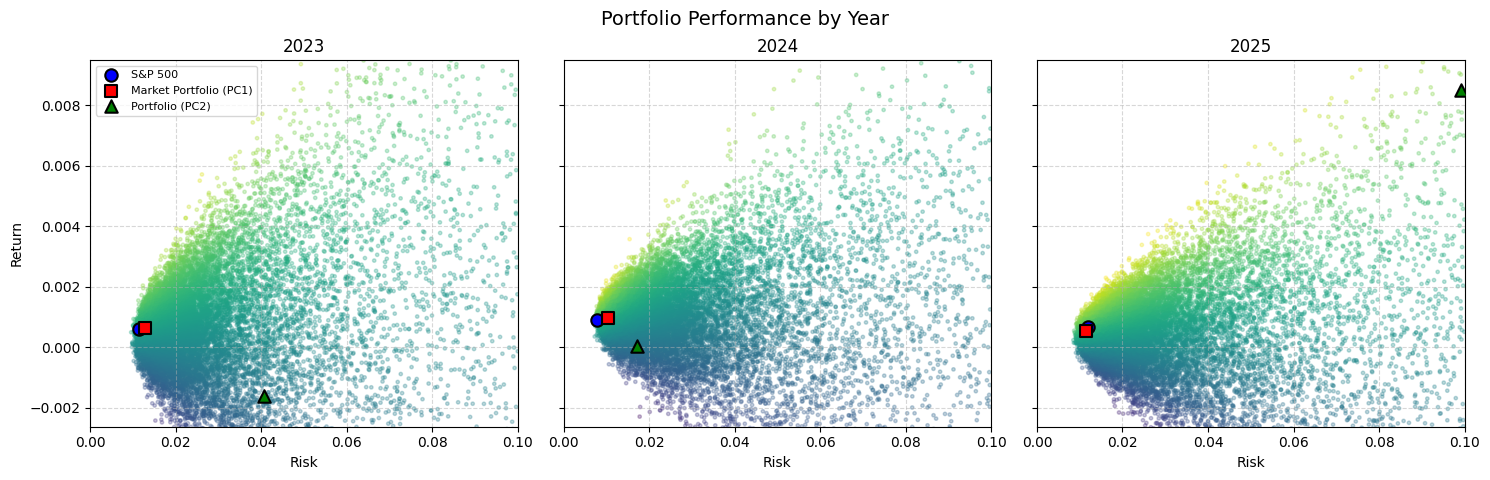

In [10]:
def plot_portfolio_data_subplots_improved(portfolio_df, closing_df, max_risk=0.10):
    """
    Improved subplot version with better layout
    """
    years = sorted(portfolio_df.index.year.unique())
    n_years = len(years)
    
    # Create subplots with shared y-axis
    fig, axes = plt.subplots(1, n_years, figsize=(5*n_years, 5), sharey=True)
    if n_years == 1:
        axes = [axes]
    
    # Portfolio styles
    styles = {
        'S&P 500': {'color': 'blue', 'marker': 'o', 'size': 80},
        'Market Portfolio (PC1)': {'color': 'red', 'marker': 's', 'size': 80},
        'Portfolio (PC2)': {'color': 'green', 'marker': '^', 'size': 80},
        'Fama French': {'color': 'orange', 'marker': '*', 'size': 80}
    }
    
    # Store scatter objects for colorbar
    scatter_objects = []
    
    for i, year in enumerate(years):
        ax = axes[i]
        year_data = portfolio_df[portfolio_df.index.year == year]
        
        # Generate random portfolios for this year
        if year == 2023:
            start_date = closing_df.index[0]
            end_date = f'{year}-08-29'
        else:
            start_date = f'{year - 1}-08-29'
            end_date = f'{year}-08-29'
        
        raw_returns = closing_df.loc[start_date:end_date].pct_change().dropna()
        mean_returns = raw_returns.mean()
        cov_matrix = raw_returns.cov()
        n_assets = len(mean_returns)
        
        # Generate random portfolios
        raw_weights = np.random.randn(20000, n_assets)
        weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)
        returns = weights @ mean_returns.values
        portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
        risks = np.sqrt(portfolio_vars)
        
        mask = risks <= max_risk
        filtered_returns = returns[mask]
        filtered_risks = risks[mask]
        
        # Plot random portfolios
        sc = ax.scatter(filtered_risks, filtered_returns, 
                       c=filtered_returns/filtered_risks,
                       cmap='viridis', s=6, alpha=0.3)
        scatter_objects.append(sc)
        
        # Plot actual portfolios
        for idx, row in year_data.iterrows():
            portfolio = row['portfolio']
            risk = row['risk']
            return_val = row['return']
            sharpe = row['sharpe']
            
            style = styles[portfolio]
            
            ax.scatter(risk, return_val, 
                      color=style['color'], 
                      marker=style['marker'],
                      s=style['size'], 
                      edgecolors='black',
                      linewidth=1.5,
                      zorder=10,
                      label=portfolio)
        
        ax.set_xlabel('Risk')
        if i == 0:
            ax.set_ylabel('Return')
        ax.set_title(f'{year}')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(0, max_risk)
        
        # Set consistent y-limits across all plots
        overall_min_return = portfolio_df['return'].min() - 0.001
        overall_max_return = portfolio_df['return'].max() + 0.001
        ax.set_ylim(overall_min_return, overall_max_return)
        
        # Only show legend on first subplot
        if i == 0:
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.suptitle('Portfolio Performance by Year', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_portfolio_data_subplots_improved(sharpe_df, closing_df)

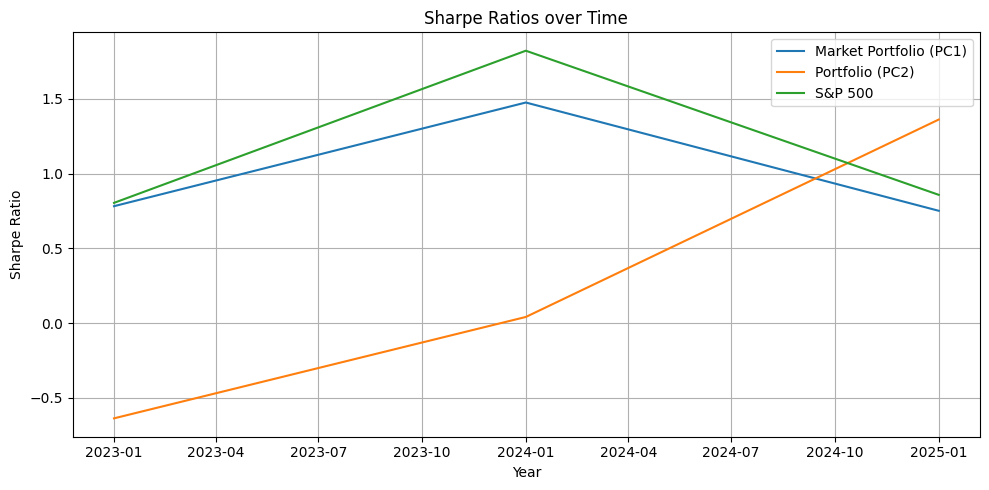

In [11]:
# pivot table
sharpe_df_reset = sharpe_df.reset_index()
pivot = pd.pivot_table(sharpe_df_reset, index='year', values='sharpe', columns='portfolio')

# plotting
plt.figure(figsize=(10, 5))
plt.plot(pivot.index, pivot.values)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Year')
plt.title('Sharpe Ratios over Time')
plt.legend(pivot.columns, loc='best')
plt.grid()
plt.xticks()
plt.tight_layout()
plt.show()

### Implement the Fama-French three-factor model

In [12]:
# # code generated with ChatGPT
# def min_idiosyncratic_risk_portfolio(residual_cov_matrix, method='long_only'):
#     """
#     Construct portfolio that minimizes idiosyncratic risk
    
#     Parameters:
#     -----------
#     residual_cov_matrix : array-like
#         Covariance matrix of Fama-French residuals (N x N)
#     method : str
#         'long_only' - no short selling, weights sum to 1
#         'fully_invested' - can short, weights sum to 1  
#         'dollar_neutral' - long/short, weights sum to 0
#     """
#     N = residual_cov_matrix.shape[0]
    
#     if method == 'long_only':
#         # No short selling constraint
#         constraints = [
#             {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum to 1
#         ]
#         bounds = [(0, 1) for _ in range(N)]  # No short selling
        
#     elif method == 'fully_invested':
#         # Can short, but fully invested
#         constraints = [
#             {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#         ]
#         bounds = [(-1, 1) for _ in range(N)]
        
#     elif method == 'dollar_neutral':
#         # Dollar neutral (long/short)
#         constraints = [
#             {'type': 'eq', 'fun': lambda x: np.sum(x)},  # Sum to 0
#             {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1},  # Total leverage = 1
#         ]
#         bounds = [(-1, 1) for _ in range(N)]
    
#     # Objective function: portfolio variance = w'Σw
#     def objective(weights):
#         return weights.T @ residual_cov_matrix @ weights
    
#     # Initial guess (equal weights)
#     x0 = np.ones(N) / N
    
#     # Optimize
#     result = minimize(objective, x0, method='SLSQP', 
#                      bounds=bounds, constraints=constraints)
    
#     return result.x, result.fun

# def idiosyncratic_risk_parity(residual_cov_matrix):
#     """
#     Risk parity portfolio based on idiosyncratic risk
#     Each asset contributes equally to portfolio idiosyncratic risk
#     """
#     # Get idiosyncratic variances (diagonal of covariance matrix)
#     idiosyncratic_variances = np.diag(residual_cov_matrix)
    
#     # Risk parity weights: inverse of standard deviation
#     weights = 1 / np.sqrt(idiosyncratic_variances)
#     weights = weights / np.sum(weights)  # Normalize
    
#     # Calculate portfolio idiosyncratic risk
#     portfolio_variance = weights.T @ residual_cov_matrix @ weights
    
#     return weights, np.sqrt(portfolio_variance)

# def max_diversification_residuals(residual_cov_matrix):
#     """
#     Maximum diversification portfolio using residual covariance matrix
#     Maximizes the diversification ratio: weighted avg vol / portfolio vol
#     """
#     N = residual_cov_matrix.shape[0]
    
#     # Individual idiosyncratic volatilities
#     idiosyncratic_vols = np.sqrt(np.diag(residual_cov_matrix))
    
#     def diversification_ratio(weights):
#         portfolio_vol = np.sqrt(weights.T @ residual_cov_matrix @ weights)
#         weighted_avg_vol = weights @ idiosyncratic_vols
#         return weighted_avg_vol / portfolio_vol
    
#     # Constraints: long only, fully invested
#     constraints = [
#         {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
#     ]
#     bounds = [(0, 1) for _ in range(N)]
    
#     # Negative because we maximize
#     def objective(weights):
#         return -diversification_ratio(weights)
    
#     x0 = np.ones(N) / N
#     result = minimize(objective, x0, method='SLSQP', 
#                      bounds=bounds, constraints=constraints)
    
#     return result.x, -result.fun

# def construct_residual_based_portfolio(ff_residuals_cov, expected_returns=None, 
#                                      target_return=None, method='min_risk'):
#     """
#     Complete portfolio construction from Fama-French residuals covariance
    
#     Parameters:
#     -----------
#     ff_residuals_cov : DataFrame
#         Covariance matrix of Fama-French residuals
#     expected_returns : array-like, optional
#         Expected returns for mean-variance optimization
#     target_return : float, optional  
#         Target return for mean-variance optimization
#     method : str
#         'min_risk' - minimum idiosyncratic risk
#         'risk_parity' - risk parity on residuals
#         'max_diversification' - maximum diversification
#         'mean_variance' - traditional mean-variance on residuals
#     """
    
#     cov_matrix = ff_residuals_cov.values
#     stocks = ff_residuals_cov.columns.tolist()
#     N = len(stocks)
    
#     if method == 'min_risk':
#         weights, risk = min_idiosyncratic_risk_portfolio(cov_matrix, 'long_only')
        
#     elif method == 'risk_parity':
#         weights, risk = idiosyncratic_risk_parity(cov_matrix)
        
#     elif method == 'max_diversification':
#         weights, risk = max_diversification_residuals(cov_matrix)
        
#     elif method == 'mean_variance':
#         if expected_returns is None:
#             raise ValueError("Expected returns required for mean-variance optimization")
#         if target_return is None:
#             target_return = np.mean(expected_returns)
        
#         weights, risk = mean_variance_residuals(cov_matrix, expected_returns, target_return)
    
#     # Create portfolio series
#     portfolio = pd.Series(weights, index=stocks, name='Weights')
    
#     # Calculate portfolio statistics
#     portfolio_variance = weights.T @ cov_matrix @ weights
#     portfolio_volatility = np.sqrt(portfolio_variance)
    
#     if expected_returns is not None:
#         portfolio_return = weights @ expected_returns
#     else:
#         portfolio_return = None
    
#     results = {
#         'weights': portfolio,
#         'idiosyncratic_volatility': portfolio_volatility,
#         'expected_return': portfolio_return,
#         'method': method
#     }
    
#     return results

# def mean_variance_residuals(residual_cov_matrix, expected_returns, target_return):
#     """
#     Mean-variance optimization using residual covariance matrix
#     """
#     N = residual_cov_matrix.shape[0]
    
#     # Objective: minimize portfolio variance
#     def objective(weights):
#         return weights.T @ residual_cov_matrix @ weights
    
#     # Constraints
#     constraints = [
#         {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Fully invested
#         {'type': 'eq', 'fun': lambda x: x @ expected_returns - target_return},  # Target return
#     ]
    
#     bounds = [(0, 1) for _ in range(N)]  # Long only
    
#     x0 = np.ones(N) / N
#     result = minimize(objective, x0, method='SLSQP', 
#                      bounds=bounds, constraints=constraints)
    
#     portfolio_variance = result.x.T @ residual_cov_matrix @ result.x
    
#     return result.x, np.sqrt(portfolio_variance)

# def construct_residual_based_portfolio(ff_residuals_cov, expected_returns=None, 
#                                      target_return=None, method='min_risk'):
#     """
#     Complete portfolio construction from Fama-French residuals covariance
    
#     Parameters:
#     -----------
#     ff_residuals_cov : DataFrame
#         Covariance matrix of Fama-French residuals
#     expected_returns : array-like, optional
#         Expected returns for mean-variance optimization
#     target_return : float, optional  
#         Target return for mean-variance optimization
#     method : str
#         'min_risk' - minimum idiosyncratic risk
#         'risk_parity' - risk parity on residuals
#         'max_diversification' - maximum diversification
#         'mean_variance' - traditional mean-variance on residuals
#     """
    
#     cov_matrix = ff_residuals_cov.values
#     stocks = ff_residuals_cov.columns.tolist()
#     N = len(stocks)
    
#     if method == 'min_risk':
#         weights, risk = min_idiosyncratic_risk_portfolio(cov_matrix, 'long_only')
        
#     elif method == 'risk_parity':
#         weights, risk = idiosyncratic_risk_parity(cov_matrix)
        
#     elif method == 'max_diversification':
#         weights, risk = max_diversification_residuals(cov_matrix)
        
#     elif method == 'mean_variance':
#         if expected_returns is None:
#             raise ValueError("Expected returns required for mean-variance optimization")
#         if target_return is None:
#             target_return = np.mean(expected_returns)
        
#         weights, risk = mean_variance_residuals(cov_matrix, expected_returns, target_return)
    
#     # Create portfolio series
#     portfolio = pd.Series(weights, index=stocks, name='Weights')
    
#     # Calculate portfolio statistics
#     portfolio_variance = weights.T @ cov_matrix @ weights
#     portfolio_volatility = np.sqrt(portfolio_variance)
    
#     if expected_returns is not None:
#         portfolio_return = weights @ expected_returns
#     else:
#         portfolio_return = None
    
#     results = {
#         'weights': portfolio,
#         'idiosyncratic_volatility': portfolio_volatility,
#         'expected_return': portfolio_return,
#         'method': method
#     }
    
#     return results

# def mean_variance_residuals(residual_cov_matrix, expected_returns, target_return):
#     """
#     Mean-variance optimization using residual covariance matrix
#     """
#     N = residual_cov_matrix.shape[0]
    
#     # Objective: minimize portfolio variance
#     def objective(weights):
#         return weights.T @ residual_cov_matrix @ weights
    
#     # Constraints
#     constraints = [
#         {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Fully invested
#         {'type': 'eq', 'fun': lambda x: x @ expected_returns - target_return},  # Target return
#     ]
    
#     bounds = [(0, 1) for _ in range(N)]  # Long only
    
#     x0 = np.ones(N) / N
#     result = minimize(objective, x0, method='SLSQP', 
#                      bounds=bounds, constraints=constraints)
    
#     portfolio_variance = result.x.T @ residual_cov_matrix @ result.x
    
#     return result.x, np.sqrt(portfolio_variance)

In [13]:
simple_df_returns = simple_df - 1 
years = ['2023', '2024', '2025']
mask = ~sharpe_df['portfolio'].str.contains('Fama French', na=False)
sharpe_df = sharpe_df[mask]

for year in years:
    start_date = f'{int(year) - 1}-08-29'
    end_date = f'{year}-08-29'
    
    year_returns = simple_df_returns.loc[start_date:end_date]
    year_ff_data = ff_data.loc[start_date:end_date]
        
    # Method 1: Equal weight
    n_assets = len(year_returns.columns)
    equal_weights = pd.Series(np.ones(n_assets) / n_assets, index=year_returns.columns)
    equal_returns = year_returns @ equal_weights
    equal_return_daily = equal_returns.mean()
    equal_risk_daily = equal_returns.std()
    rf_daily = year_ff_data['RF'].mean() / 100 / 252
    excess_equal_daily = equal_return_daily - rf_daily
    equal_sharpe_annual = (excess_equal_daily / equal_risk_daily) * np.sqrt(252) if equal_risk_daily > 1e-10 else 0
        
    # Method 2: Minimum variance
    try:
        cov_matrix = year_returns.cov()
        inv_cov = np.linalg.pinv(cov_matrix)
        ones = np.ones(n_assets)
        min_var_weights = inv_cov @ ones / (ones.T @ inv_cov @ ones)
        min_var_returns = year_returns @ min_var_weights
        min_var_return_daily = min_var_returns.mean()
        min_var_risk_daily = min_var_returns.std()
        excess_min_var_daily = min_var_return_daily - rf_daily
        min_var_sharpe_annual = (excess_min_var_daily / min_var_risk_daily) * np.sqrt(252) if min_var_risk_daily > 1e-10 else 0
    except:
        min_var_sharpe_annual = 0
    
    # Method 3: Risk parity based on volatility
    volatilities = year_returns.std()
    risk_parity_weights = (1 / volatilities) / (1 / volatilities).sum()
    risk_parity_returns = year_returns @ risk_parity_weights
    rp_return_daily = risk_parity_returns.mean()
    rp_risk_daily = risk_parity_returns.std()
    excess_rp_daily = rp_return_daily - rf_daily
    rp_sharpe_annual = (excess_rp_daily / rp_risk_daily) * np.sqrt(252) if rp_risk_daily > 1e-10 else 0
    
    # best method
    methods = {
        'Equal Weight': equal_sharpe_annual,
        'Min Variance': min_var_sharpe_annual,
        'Risk Parity': rp_sharpe_annual
    }
    
    best_method = max(methods, key=methods.get)
    best_sharpe = methods[best_method]
    
    # final values based on best method
    if best_method == 'Equal Weight':
        final_return = equal_return_daily
        final_risk = equal_risk_daily
        portfolio_name = "Fama French" # (Equal Wt)
    elif best_method == 'Min Variance':
        final_return = min_var_return_daily
        final_risk = min_var_risk_daily
        portfolio_name = "Fama French" # (Min Var)
    else:  # Risk Parity
        final_return = rp_return_daily
        final_risk = rp_risk_daily
        portfolio_name = "Fama French" # (Risk Parity)
        
    # Add to sharpe_df
    new_index = pd.Timestamp(f'{year}-01-01')
    new_row = pd.DataFrame({
        'portfolio': [portfolio_name],
        'risk': [final_risk],
        'return': [final_return],
        'sharpe': [best_sharpe]
    }, index=[new_index])
    new_row.index.name = 'year'
    
    sharpe_df = pd.concat([sharpe_df, new_row])

In [14]:
sharpe_df

,portfolio,risk,return,sharpe
year,,,,
2023-01-01,S&P 500,0.011480,0.000582,0.803732
2023-01-01,Market Portfolio (PC1),0.012774,0.000630,0.781432
2023-01-01,Portfolio (PC2),0.040713,-0.001634,-0.637480
2024-01-01,S&P 500,0.007793,0.000895,1.821204
2024-01-01,Market Portfolio (PC1),0.010393,0.000966,1.474760
2024-01-01,Portfolio (PC2),0.017112,0.000044,0.040515
2025-01-01,S&P 500,0.011997,0.000649,0.857262
2025-01-01,Market Portfolio (PC1),0.011401,0.000540,0.750594
2025-01-01,Portfolio (PC2),0.099056,0.008493,1.360943


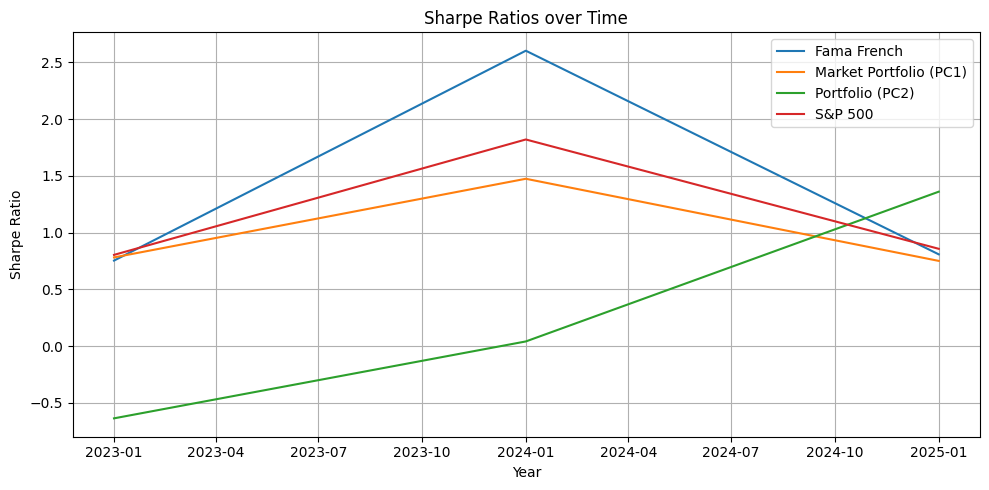

In [15]:
# pivot table
sharpe_df_reset = sharpe_df.reset_index()
pivot = pd.pivot_table(sharpe_df_reset, index='year', values='sharpe', columns='portfolio')

# plotting
plt.figure(figsize=(10, 5))
plt.plot(pivot.index, pivot.values)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Year')
plt.title('Sharpe Ratios over Time')
plt.legend(pivot.columns, loc='best')
plt.grid()
plt.xticks()
plt.tight_layout()
plt.show()

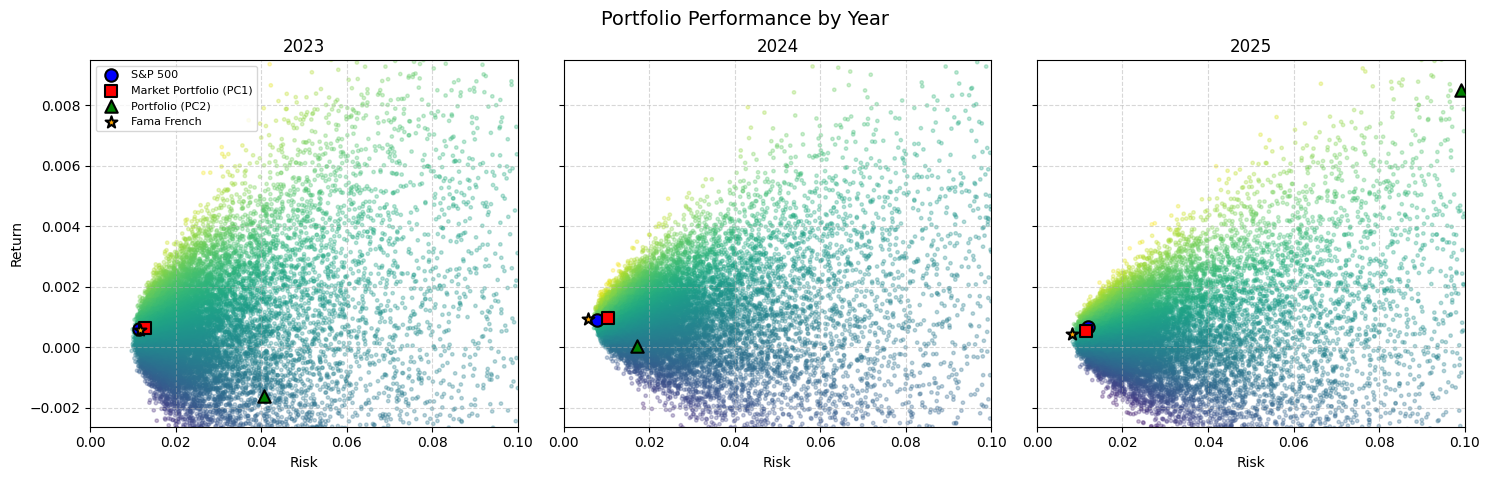

In [16]:
plot_portfolio_data_subplots_improved(sharpe_df, closing_df)

## Intermediate Goal

Plan:
1. Implement the RIE Markowitz portfolio optimization
      - Estimate the covariance matrix by doing RIE on the log returns
2. Check which eigenvectors are significant using Marchenco-Pastur and pick one to use for the portfolio (this should be the second largest eigenvalue).
3. Compare its fit to the efficient frontier.

### Implement the RIE Markowitz portfolio optimization

In [17]:
def compute_RIE_eig_on_year(norm_returns, year):
    # compute RIE-cleaned correlation matrix
    cleansed_rie = rie_estimator.get_rie(norm_returns.get_group(year), normalize=True, max_ones=True)

    # eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(cleansed_rie)
    eigvals = np.real(eigvals)
    return eigvals, eigvecs

eigvals, eigvecs = compute_RIE_eig_on_year(norm_returns, 2022)

NameError: name 'norm_returns' is not defined

### Check which eigenvectors are significant using Marchenco-Pastur and pick one to use for the portfolio

In [ ]:
def do_marchenco(eigvals, eigvecs, year):
    # Marčenko–Pastur parameters
    T, N = norm_returns.get_group(year).shape
    q = N / T
    lambda_minus = (1 - np.sqrt(q))**2
    lambda_plus = (1 + np.sqrt(q))**2

    # Define MP PDF
    def mp_pdf(lmbda, q):
        lm, lp = (1 - np.sqrt(q))**2, (1 + np.sqrt(q))**2
        pdf = np.zeros_like(lmbda)
        mask = (lmbda >= lm) & (lmbda <= lp)
        pdf[mask] = np.sqrt((lp - lmbda[mask]) * (lmbda[mask] - lm)) / (2 * np.pi * q * lmbda[mask])
        return pdf

    lambda_grid = np.linspace(0, max(eigvals) * 1.1, 1000)
    mp_density = mp_pdf(lambda_grid, q)

    # plotting
    plt.figure(figsize=(9, 5))
    plt.hist(eigvals, bins=50, density=True, alpha=0.6, label='Empirical eigenvalues')
    plt.plot(lambda_grid, mp_density, 'r-', lw=2, label='Marčenko–Pastur PDF')
    plt.axvline(lambda_minus, color='k', linestyle='--', label=r'$\lambda_-$')
    plt.axvline(lambda_plus, color='k', linestyle='--', label=r'$\lambda_+$')

    plt.title('Empirical Eigenvalue Spectrum vs Marčenko–Pastur Distribution')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    # force x-axis ticks to integer alignment
    max_tick = int(np.ceil(max(eigvals)))
    plt.xticks(np.arange(0, max_tick + 1, 1))

    plt.tight_layout()
    plt.show()

    # identify significant eigenvalues (above the MP upper bound)
    significant_mask = eigvals > lambda_plus

    # extract those eigenvalues and their corresponding eigenvectors
    significant_eigvals = eigvals[significant_mask]
    significant_eigvecs = eigvecs[:, significant_mask]

    print(f"Number of significant eigenvalues: {significant_eigvals.size}")
    print("Significant eigenvalues:")
    print(significant_eigvals)

    print("\nShape of corresponding eigenvector matrix:", significant_eigvecs.shape)
    print("(Columns correspond to significant principal components.)")

    # inspect first significant eigenvector
    if significant_eigvals.size > 0:
        print("\nFirst significant eigenvector:")
        print(significant_eigvecs[:, 0])
    return significant_eigvecs

significant_eigvecs = do_marchenco(eigvals, eigvecs, 2022)

In [ ]:
# Assuming norm_returns is your DataFrame (T x N) with stock names as columns
stock_names = norm_returns.get_group(2022).columns

v = significant_eigvecs

# Compute squared, normalized weights
weights_sq = v**2 / np.sum(v**2)

pc1_sq_weights = pd.DataFrame({
    'Stock': stock_names,
    'Weight': weights_sq
})

pc1_sq_series = pd.Series(data=pc1_sq_weights['Weight'].values,
                          index=pc1_sq_weights['Stock'],
                          name='Weight')


In [ ]:
pc1_sq_series

### Compare its fit to the efficient frontier.

In [ ]:
# --- Inputs ---
pc0.name = "PC0"
pc1.name = "PC1"

approaches = [pc0, pc1, pc1_sq_series]
stdev_range = (0.001, 0.1)

# --- Compute mean returns and covariance ---
mean_returns = returns_df.get_group(2022).mean()
cov_matrix = returns_df.get_group(2022).cov()
n_assets = len(mean_returns)

# --- Generate random portfolios using normalized Gaussian weights ---
n_portfolios = 90000
raw_weights = np.random.randn(n_portfolios, n_assets)   # Gaussian draws
weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)

# Expected returns of each portfolio
returns = weights @ mean_returns.values


# Portfolio variances and standard deviations
portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
risks = np.sqrt(portfolio_vars)

# --- Filter random portfolios by stdev ---
mask = (risks >= stdev_range[0]) & (risks <= stdev_range[1])
filtered_returns = returns[mask]
filtered_risks = risks[mask]

# --- Plot random portfolios ---
plt.figure(figsize=(10, 7))
plt.scatter(filtered_risks, filtered_returns, c=filtered_returns/filtered_risks,
            cmap='viridis', s=10, alpha=0.5, label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio (Return/Risk)')

# --- Plot approaches portfolios (all, unfiltered) ---
for i, approach in enumerate(approaches):
    w = approach.reindex(mean_returns.index).fillna(0).values
    ret = np.dot(w, mean_returns.values)
    risk = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
    
    label = approach.name if approach.name else f'Portfolio {i+1}'
    
    plt.scatter(risk, ret, color='red', s=60, edgecolors='black', zorder=5)
    plt.text(risk, ret, label, fontsize=9, ha='left', va='bottom')

plt.title(f'Expected Return vs Risk (with Theoretical Frontier)\nFiltered {stdev_range[0]:.3f} ≤ σ ≤ {stdev_range[1]:.3f}')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return (Mean)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
mean_returns.mean()

## Advanced Goal

Plan:
As per the study done by Molero-Gonzales et al., (2023), the steps we will follow are the ff:
1. Apply the Fama-French 3 Factor Model on the log returns matrix.
2. Turn the coefficients for each of the factors for each stock in the portfolio into a matrix.
3. Apply RMT.
      - Eigenvalue decomposition
      - Identify the significant eigenvectors using the Tracy-Widom distribution.
4. Create a portfolio out of the significant factors and the residuals.
5. Compare its performance against the matrix in the Basic Goal section to predict stock risk.

### Whole Dataset Onatski Test

In [29]:
def onatski_test_statistic(eigenvalues, k0, k1):
    """
    Calculate Onatski test statistic R
    """
    ratios = []
    for i in range(k0, k1):
        if i + 2 < len(eigenvalues):
            ratio = (eigenvalues[i] - eigenvalues[i+1]) / (eigenvalues[i+1] - eigenvalues[i+2])
            ratios.append(ratio)
    return max(ratios) if ratios else 0

def onatski_critical_values():
    """
    Critical values for Onatski test (from Onatski 2009 paper)
    """
    return {
        1: {0.15: 2.75, 0.10: 3.33, 0.09: 3.50, 0.08: 3.69, 0.07: 3.92, 
            0.06: 4.20, 0.05: 4.52, 0.04: 5.02, 0.03: 5.62, 0.02: 6.55, 0.01: 8.74},
        2: {0.15: 3.62, 0.10: 4.31, 0.09: 4.49, 0.08: 4.72, 0.07: 4.99,
            0.06: 5.31, 0.05: 5.73, 0.04: 6.26, 0.03: 6.91, 0.02: 8.15, 0.01: 10.52},
    }

def determine_factors_table(returns_data, max_factors=5):
    """
    Determine number of factors using Onatski test and return results as DataFrame
    """
    # eigenvalues from covar matrix
    cov_matrix = returns_data.cov()
    eigenvalues = eigh(cov_matrix, eigvals_only=True)
    eigenvalues = np.sort(eigenvalues)[::-1]
    
    critical_values = onatski_critical_values()
    
    # results table
    results_data = []
    for alpha in [0.01, 0.05, 0.10]:
        k_estimated = 0
        test_details = []
        
        for k0 in range(max_factors):
            k1 = max_factors
            if (k1 - k0) in critical_values:
                R_stat = onatski_test_statistic(eigenvalues, k0, k1)
                critical_val = critical_values[k1 - k0].get(alpha, 999)
                
                # test result
                if R_stat <= critical_val:
                    result = f"Fail to reject H₀ (k={k0})"
                    k_estimated = k0
                    test_details.append({
                        'Hypothesis Test': f"H₀: k={k0} vs H₁: {k0}<k≤{k1}",
                        'R Statistic': round(R_stat, 4),
                        f'Critical Value (α={alpha})': round(critical_val, 4),
                        'Result': result,
                        'Estimated Factors': k_estimated
                    })
                    break
                else:
                    result = f"Reject H₀ (k>{k0})"
                    test_details.append({
                        'Hypothesis Test': f"H₀: k={k0} vs H₁: {k0}<k≤{k1}",
                        'R Statistic': round(R_stat, 4),
                        f'Critical Value (α={alpha})': round(critical_val, 4),
                        'Result': result,
                        'Estimated Factors': '-'
                    })
        
        # final result for this alpha
        results_data.append({
            'Significance Level (α)': alpha,
            'R Statistic': round(R_stat, 4),
            'Critical Value': round(critical_val, 4),
            'Test Result': 'Fail to reject H₀' if R_stat <= critical_val else 'Reject H₀',
            'Estimated Factors': k_estimated,
            'Final Hypothesis': f"H₀: k={k_estimated}"
        })
    
    # main results table
    results_df = pd.DataFrame(results_data)
    
    # detailed test steps table
    detailed_data = []
    for alpha in [0.01, 0.05, 0.10]:
        k_estimated = 0
        for k0 in range(max_factors):
            k1 = max_factors
            if (k1 - k0) in critical_values:
                R_stat = onatski_test_statistic(eigenvalues, k0, k1)
                critical_val = critical_values[k1 - k0].get(alpha, 999)
                
                if R_stat <= critical_val:
                    result = "Fail to reject H₀"
                    k_estimated = k0
                    detailed_data.append({
                        'α': alpha,
                        'Test Step': f"Test k={k0}",
                        'Hypothesis': f"H₀: k={k0} vs H₁: {k0}<k≤{k1}",
                        'R Statistic': round(R_stat, 4),
                        'Critical Value': round(critical_val, 4),
                        'Result': result,
                        'Decision': f"Stop → k={k_estimated}"
                    })
                    break
                else:
                    result = "Reject H₀"
                    detailed_data.append({
                        'α': alpha,
                        'Test Step': f"Test k={k0}",
                        'Hypothesis': f"H₀: k={k0} vs H₁: {k0}<k≤{k1}",
                        'R Statistic': round(R_stat, 4),
                        'Critical Value': round(critical_val, 4),
                        'Result': result,
                        'Decision': f"Continue testing"
                    })
    
    detailed_df = pd.DataFrame(detailed_data)
    
    # eigenvalues table
    eigen_df = pd.DataFrame({
        'Eigenvalue Rank': range(1, 11),
        'Eigenvalue': eigenvalues[:10],
        'Cumulative Variance %': np.cumsum(eigenvalues[:10]) / np.sum(eigenvalues) * 100
    })
    
    return results_df, detailed_df, eigen_df, eigenvalues

# run analysis and get tables
returns_data = closing_df.pct_change().dropna()
results_df, detailed_df, eigen_df, eigenvalues = determine_factors_table(returns_data, max_factors=5)

# Display results
print("Final Test Results")
display(results_df.style.set_properties(**{'background-color': '#f0f8ff', 'border': '1px solid black'}))

print("Testing Steps")
display(detailed_df.style.set_properties(**{'background-color': '#fff0f5', 'border': '1px solid black'}))

print("First 10 Eigenvalues")
display(eigen_df.style.format({
    'Eigenvalue': '{:.6f}',
    'Cumulative Variance %': '{:.2f}%'
}).set_properties(**{'background-color': '#f0fff0', 'border': '1px solid black'}))

Final Test Results


,Significance Level (α),R Statistic,Critical Value,Test Result,Estimated Factors,Final Hypothesis
0,0.010000,1.400200,10.520000,Fail to reject H₀,3,H₀: k=3
1,0.050000,1.400200,5.730000,Fail to reject H₀,3,H₀: k=3
2,0.100000,1.400200,4.310000,Fail to reject H₀,3,H₀: k=3


Testing Steps


,α,Test Step,Hypothesis,R Statistic,Critical Value,Result,Decision
0,0.010000,Test k=3,H₀: k=3 vs H₁: 3<k≤5,1.400200,10.520000,Fail to reject H₀,Stop → k=3
1,0.050000,Test k=3,H₀: k=3 vs H₁: 3<k≤5,1.400200,5.730000,Fail to reject H₀,Stop → k=3
2,0.100000,Test k=3,H₀: k=3 vs H₁: 3<k≤5,1.400200,4.310000,Fail to reject H₀,Stop → k=3


First 10 Eigenvalues


,Eigenvalue Rank,Eigenvalue,Cumulative Variance %
0,1,0.003277,35.06%
1,2,0.000727,42.83%
2,3,0.000554,48.76%
3,4,0.000513,54.25%
4,5,0.000451,59.07%
5,6,0.000384,63.17%
6,7,0.000336,66.77%
7,8,0.000310,70.08%
8,9,0.000236,72.60%
9,10,0.000225,75.01%


Based on the results above, the data shows exactly 3 statistically significant factors across all significance levels. 
However, it must be noted that the market factor is the strongest among the three.

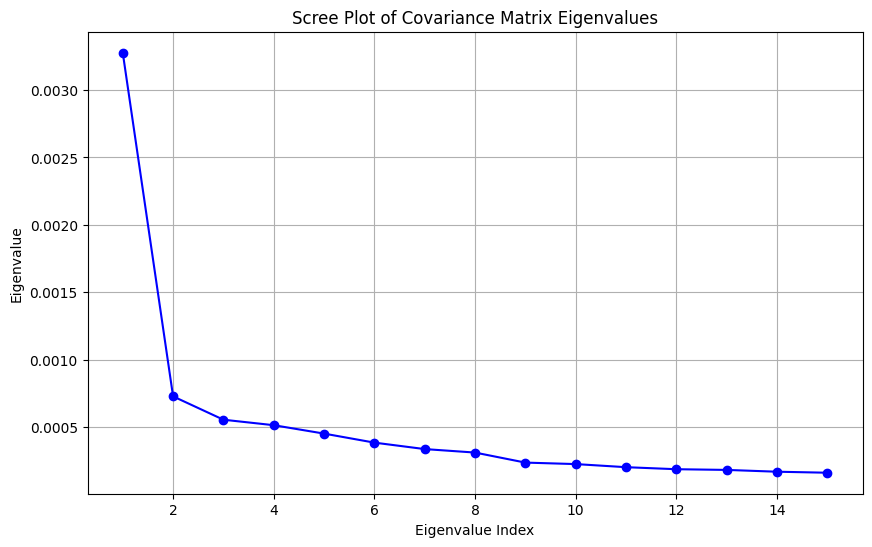

In [21]:
cov_matrix = returns_data.cov()
eigenvalues = eigh(cov_matrix, eigvals_only=True)
eigenvalues = np.sort(eigenvalues)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues[:15]) + 1), eigenvalues[:15], 'bo-')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Covariance Matrix Eigenvalues')
plt.grid(True)
plt.show()

### Yearly Onatski Test

,Period,R Statistic,Critical Value (α=0.05),Estimated Factors,Variance Explained by 1st Factor,Variance Explained by 3 Factors,Test Result,Hypothesis
0,2022-Aug to 2023-Aug,2.642127,5.73,3,94.328516,99.615778,Fail to reject H₀,H₀: k=3
1,2023-Aug to 2024-Aug,2.470861,5.73,3,94.239733,99.639954,Fail to reject H₀,H₀: k=3
2,2024-Aug to 2025-Aug,1.808624,5.73,3,94.146078,99.540677,Fail to reject H₀,H₀: k=3


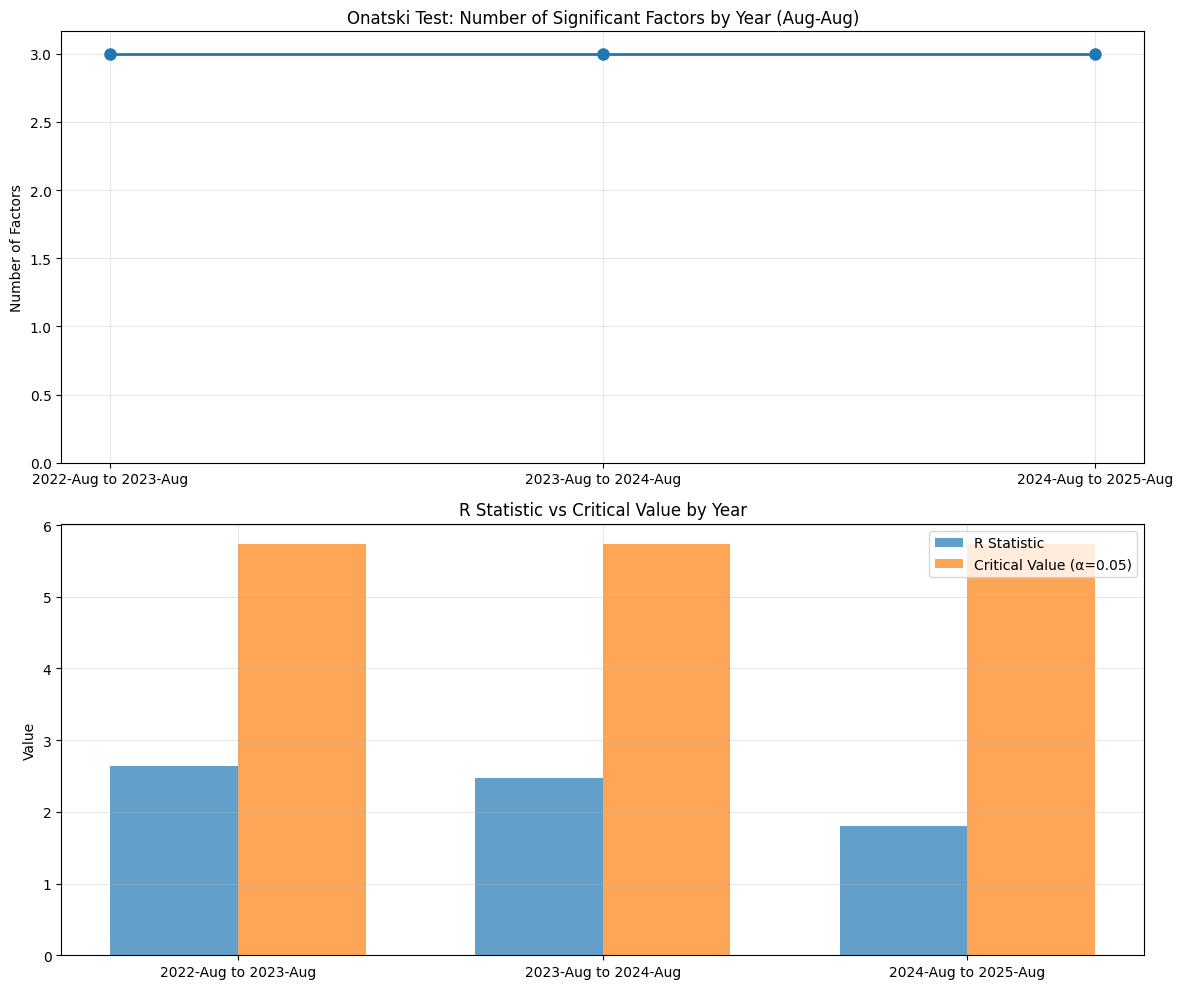

In [44]:
def onatski_test_statistic(eigenvalues, k0, k1):
    """
    Calculate Onatski test statistic R
    """
    ratios = []
    for i in range(k0, k1):
        if i + 2 < len(eigenvalues):
            ratio = (eigenvalues[i] - eigenvalues[i+1]) / (eigenvalues[i+1] - eigenvalues[i+2])
            ratios.append(ratio)
    return max(ratios) if ratios else 0

def onatski_critical_values():
    """
    Critical values for Onatski test (from Onatski 2009 paper)
    """
    return {
        1: {0.15: 2.75, 0.10: 3.33, 0.09: 3.50, 0.08: 3.69, 0.07: 3.92, 
            0.06: 4.20, 0.05: 4.52, 0.04: 5.02, 0.03: 5.62, 0.02: 6.55, 0.01: 8.74},
        2: {0.15: 3.62, 0.10: 4.31, 0.09: 4.49, 0.08: 4.72, 0.07: 4.99,
            0.06: 5.31, 0.05: 5.73, 0.04: 6.26, 0.03: 6.91, 0.02: 8.15, 0.01: 10.52},
    }

def determine_factors_for_period(returns_data, period_name, alpha=0.05):
    """
    Run Onatski test for a specific period and return results
    """
    # Calculate covariance matrix
    cov_matrix = returns_data.cov()
    
    # Get eigenvalues (descending order)
    eigenvalues = eigh(cov_matrix, eigvals_only=True)
    eigenvalues = np.sort(eigenvalues)[::-1]
    
    critical_values = onatski_critical_values()
    max_factors = 5
    
    # Sequential testing
    k_estimated = 0
    R_stat = 0
    critical_val = 999
    
    for k0 in range(max_factors):
        k1 = max_factors
        if (k1 - k0) in critical_values:
            R_stat = onatski_test_statistic(eigenvalues, k0, k1)
            critical_val = critical_values[k1 - k0].get(alpha, 999)
            
            if R_stat <= critical_val:
                k_estimated = k0
                break
    
    # Calculate variance explained
    total_variance = np.sum(eigenvalues)
    variance_explained = np.cumsum(eigenvalues) / total_variance * 100
    
    return {
        'Period': period_name,
        'Start Date': returns_data.index[0].strftime('%Y-%m-%d'),
        'End Date': returns_data.index[-1].strftime('%Y-%m-%d'),
        'Trading Days': len(returns_data),
        'R Statistic': R_stat,
        'Critical Value (α=0.05)': critical_val,
        'Estimated Factors': k_estimated,
        'Variance Explained by 1st Factor': variance_explained[0] if len(variance_explained) > 0 else 0,
        'Variance Explained by 3 Factors': variance_explained[2] if len(variance_explained) > 2 else 0,
        'Test Result': 'Fail to reject H₀' if R_stat <= critical_val else 'Reject H₀',
        'Hypothesis': f'H₀: k={k_estimated}'
    }

# Define years based on your data
def analyze_by_august_years(returns_data):
    """Analyze periods from Aug-29 to Aug-29 each year"""
    yearly_results = []
    
    # Get the range of years in your data
    start_year = returns_data.index[0].year
    end_year = returns_data.index[-1].year
    
    for year in range(start_year + 1, end_year + 1):  # Start from second year
        start_date = f'{year-1}-08-29'
        end_date = f'{year}-08-29'
                
        try:
            period_data = returns_data[(returns_data.index >= start_date) & 
                                     (returns_data.index <= end_date)]
            
            if len(period_data) > 100:
                result = determine_factors_for_period(period_data, f'{year-1}-Aug to {year}-Aug')
                yearly_results.append(result)
            else:
                print(f"Only {len(period_data)} trading days for {year-1}-{year} - skipping")
                
        except Exception as e:
            print(f"Error processing {year-1}-{year}: {e}")
            continue
    
    return yearly_results

# Run the analysis with your specific date format
yearly_results = analyze_by_august_years(returns_data)

if yearly_results:
    # Create results table
    results_df = pd.DataFrame(yearly_results)
    
    # Display main results
    cols_drop = [
        'Start Date', 'End Date', 'Trading Days'
    ]
    results_df.drop(columns=cols_drop, inplace=True)
    display(results_df)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Number of factors over time
    ax1.plot(results_df['Period'], results_df['Estimated Factors'], 'o-', linewidth=2, markersize=8)
    ax1.set_ylabel('Number of Factors')
    ax1.set_title('Onatski Test: Number of Significant Factors by Year (Aug-Aug)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot 2: R statistic vs critical value
    x_pos = range(len(results_df))
    width = 0.35
    ax2.bar([p - width/2 for p in x_pos], results_df['R Statistic'], width, label='R Statistic', alpha=0.7)
    ax2.bar([p + width/2 for p in x_pos], results_df['Critical Value (α=0.05)'], width, label='Critical Value (α=0.05)', alpha=0.7)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(results_df['Period'])
    ax2.set_ylabel('Value')
    ax2.set_title('R Statistic vs Critical Value by Year')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

📅 METHODOLOGY 1: YEARLY ANALYSIS (Aug-to-Aug)
📊 YEARLY RESULTS (Aug-to-Aug)


,Period,Trading Days,R Statistic,Critical Value (α=0.05),Estimated Factors,Variance Explained by 1st Factor
0,2022-Aug to 2023-Aug,249,2.642127,5.73,3,94.328516
1,2023-Aug to 2024-Aug,253,2.470861,5.73,3,94.239733
2,2024-Aug to 2025-Aug,251,1.808624,5.73,3,94.146078



🔄 METHODOLOGY 2: ROLLING WINDOW ANALYSIS
📊 ROLLING WINDOW RESULTS (252-day windows, 63-day steps)


,Period,Start Date,End Date,Trading Days,R Statistic,Critical Value (α=0.05),Estimated Factors,Variance Explained by 1st Factor
0,Window 1,2022-09-01,2023-09-01,252,3.082979,5.73,3,94.155922
1,Window 2,2022-12-01,2023-12-01,252,1.438084,5.73,3,94.645809
2,Window 3,2023-03-06,2024-03-05,252,1.185404,5.73,3,93.353543
3,Window 4,2023-06-05,2024-06-04,252,2.518634,5.73,3,95.137948
4,Window 5,2023-09-05,2024-09-04,252,3.581232,5.73,3,94.265391
5,Window 6,2023-12-04,2024-12-03,252,2.855885,5.73,3,94.947812
6,Window 7,2024-03-06,2025-03-07,252,5.749828,4.52,0,93.462841
7,Window 8,2024-06-05,2025-06-06,252,1.735708,5.73,3,95.095178


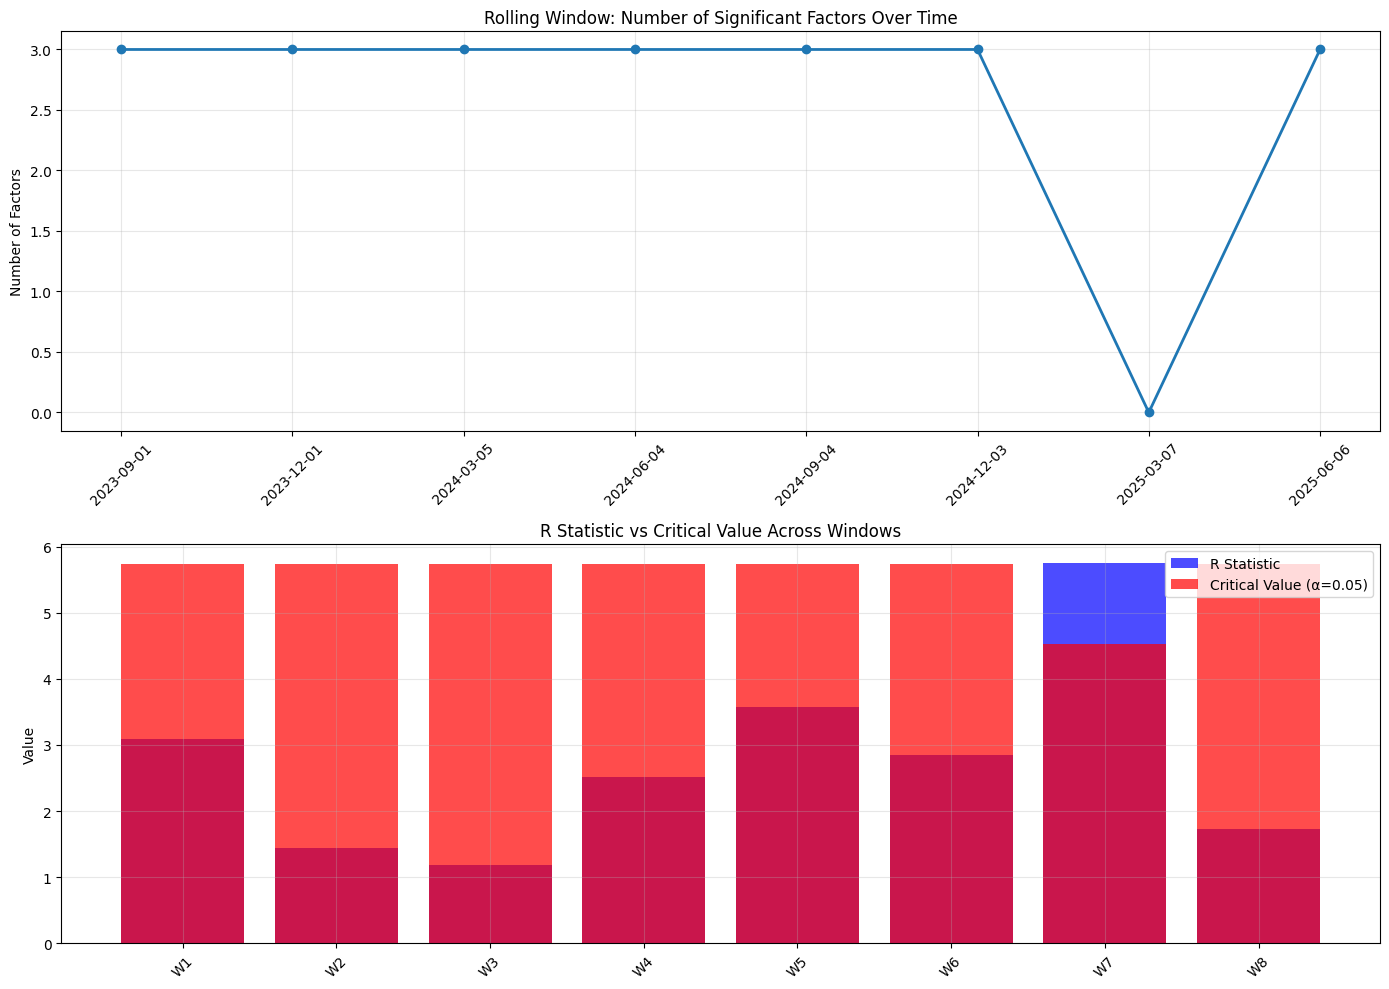


📈 ROLLING WINDOW SUMMARY:
Total windows analyzed: 8
Average factors: 2.62
Factor range: 0 to 3
Windows with 1 factor: 0
Windows with >1 factor: 7

🔍 COMPARISON OF BOTH METHODOLOGIES
✅ Both methodologies completed successfully
Yearly periods: 3
Rolling windows: 8
Average factors - Yearly: 3.00
Average factors - Rolling: 2.62

💡 DATA CHARACTERISTICS:
Total period: 2022-09-01 to 2025-08-29
Total trading days: 751
Number of assets: 32


In [47]:
import pandas as pd
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def onatski_test_statistic(eigenvalues, k0, k1):
    """
    Calculate Onatski test statistic R
    """
    ratios = []
    for i in range(k0, k1):
        if i + 2 < len(eigenvalues):
            ratio = (eigenvalues[i] - eigenvalues[i+1]) / (eigenvalues[i+1] - eigenvalues[i+2])
            ratios.append(ratio)
    return max(ratios) if ratios else 0

def onatski_critical_values():
    """
    Critical values for Onatski test (from Onatski 2009 paper)
    """
    return {
        1: {0.15: 2.75, 0.10: 3.33, 0.09: 3.50, 0.08: 3.69, 0.07: 3.92, 
            0.06: 4.20, 0.05: 4.52, 0.04: 5.02, 0.03: 5.62, 0.02: 6.55, 0.01: 8.74},
        2: {0.15: 3.62, 0.10: 4.31, 0.09: 4.49, 0.08: 4.72, 0.07: 4.99,
            0.06: 5.31, 0.05: 5.73, 0.04: 6.26, 0.03: 6.91, 0.02: 8.15, 0.01: 10.52},
    }

def run_onatski_test(returns_data, period_name, alpha=0.05):
    """
    Run complete Onatski test for a given dataset
    """
    # Calculate covariance matrix and eigenvalues
    cov_matrix = returns_data.cov()
    eigenvalues = eigh(cov_matrix, eigvals_only=True)
    eigenvalues = np.sort(eigenvalues)[::-1]
    
    critical_values = onatski_critical_values()
    max_factors = 5
    
    # Sequential testing
    k_estimated = 0
    R_stat = 0
    critical_val = 999
    
    for k0 in range(max_factors):
        k1 = max_factors
        if (k1 - k0) in critical_values:
            R_stat = onatski_test_statistic(eigenvalues, k0, k1)
            critical_val = critical_values[k1 - k0].get(alpha, 999)
            
            if R_stat <= critical_val:
                k_estimated = k0
                break
    
    # Calculate variance explained
    total_variance = np.sum(eigenvalues)
    variance_explained = np.cumsum(eigenvalues) / total_variance * 100
    
    return {
        'Period': period_name,
        'Start Date': returns_data.index[0].strftime('%Y-%m-%d'),
        'End Date': returns_data.index[-1].strftime('%Y-%m-%d'),
        'Trading Days': len(returns_data),
        'R Statistic': R_stat,
        'Critical Value (α=0.05)': critical_val,
        'Estimated Factors': k_estimated,
        'Variance Explained by 1st Factor': variance_explained[0] if len(variance_explained) > 0 else 0,
        'Test Result': 'Fail to reject H₀' if R_stat <= critical_val else 'Reject H₀',
        'Eigenvalues': eigenvalues
    }

# METHODOLOGY 1: Yearly Analysis (Aug-to-Aug)
print("📅 METHODOLOGY 1: YEARLY ANALYSIS (Aug-to-Aug)")
print("=" * 50)

def yearly_analysis(returns_data):
    """Analyze August-to-August yearly periods"""
    yearly_results = []
    
    start_year = returns_data.index[0].year
    end_year = returns_data.index[-1].year
    
    for year in range(start_year + 1, end_year + 1):
        start_date = f'{year-1}-08-29'
        end_date = f'{year}-08-29'
        
        try:
            period_data = returns_data[(returns_data.index >= start_date) & 
                                     (returns_data.index <= end_date)]
            
            if len(period_data) > 100:
                result = run_onatski_test(period_data, f'{year-1}-Aug to {year}-Aug')
                yearly_results.append(result)
        except:
            continue
    
    return yearly_results

yearly_results = yearly_analysis(returns_data)

if yearly_results:
    yearly_df = pd.DataFrame(yearly_results)
    print("📊 YEARLY RESULTS (Aug-to-Aug)")
    display(yearly_df[['Period', 'Trading Days', 'R Statistic', 'Critical Value (α=0.05)', 
                      'Estimated Factors', 'Variance Explained by 1st Factor']])
else:
    print("❌ No complete yearly periods found")

# METHODOLOGY 2: Rolling Window Analysis (252-day windows, 63-day steps)
print("\n🔄 METHODOLOGY 2: ROLLING WINDOW ANALYSIS")
print("=" * 50)

def rolling_window_analysis(returns_data, window_size=252, step_size=63):
    """Rolling window analysis like the paper"""
    rolling_results = []
    dates = returns_data.index
    
    for start_idx in range(0, len(returns_data) - window_size + 1, step_size):
        end_idx = start_idx + window_size
        window_data = returns_data.iloc[start_idx:end_idx]
        
        try:
            period_name = f"Window {len(rolling_results)+1}"
            result = run_onatski_test(window_data, period_name)
            result['Start Date'] = dates[start_idx].strftime('%Y-%m-%d')
            result['End Date'] = dates[end_idx-1].strftime('%Y-%m-%d')
            rolling_results.append(result)
        except Exception as e:
            continue
    
    return rolling_results

rolling_results = rolling_window_analysis(returns_data, window_size=252, step_size=63)

if rolling_results:
    rolling_df = pd.DataFrame(rolling_results)
    print("📊 ROLLING WINDOW RESULTS (252-day windows, 63-day steps)")
    display(rolling_df[['Period', 'Start Date', 'End Date', 'Trading Days', 'R Statistic', 
                       'Critical Value (α=0.05)', 'Estimated Factors', 'Variance Explained by 1st Factor']])
    
    # Plot rolling window results
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Factors over time
    plt.subplot(2, 1, 1)
    plt.plot(rolling_df['End Date'], rolling_df['Estimated Factors'], 'o-', linewidth=2, markersize=6)
    plt.ylabel('Number of Factors')
    plt.title('Rolling Window: Number of Significant Factors Over Time')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot 2: R statistic vs critical value
    plt.subplot(2, 1, 2)
    x_pos = range(len(rolling_df))
    plt.bar(x_pos, rolling_df['R Statistic'], alpha=0.7, label='R Statistic', color='blue')
    plt.bar(x_pos, rolling_df['Critical Value (α=0.05)'], alpha=0.7, label='Critical Value (α=0.05)', color='red')
    plt.xticks(x_pos, [f"W{i+1}" for i in x_pos], rotation=45)
    plt.ylabel('Value')
    plt.title('R Statistic vs Critical Value Across Windows')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 ROLLING WINDOW SUMMARY:")
    print(f"Total windows analyzed: {len(rolling_results)}")
    print(f"Average factors: {rolling_df['Estimated Factors'].mean():.2f}")
    print(f"Factor range: {rolling_df['Estimated Factors'].min()} to {rolling_df['Estimated Factors'].max()}")
    print(f"Windows with 1 factor: {len(rolling_df[rolling_df['Estimated Factors'] == 1])}")
    print(f"Windows with >1 factor: {len(rolling_df[rolling_df['Estimated Factors'] > 1])}")
    
else:
    print("❌ No complete rolling windows found")

# COMPARISON OF BOTH METHODOLOGIES
print("\n🔍 COMPARISON OF BOTH METHODOLOGIES")
print("=" * 50)

if yearly_results and rolling_results:
    print("✅ Both methodologies completed successfully")
    print(f"Yearly periods: {len(yearly_results)}")
    print(f"Rolling windows: {len(rolling_results)}")
    
    # Compare average factors
    yearly_avg = pd.DataFrame(yearly_results)['Estimated Factors'].mean()
    rolling_avg = pd.DataFrame(rolling_results)['Estimated Factors'].mean()
    
    print(f"Average factors - Yearly: {yearly_avg:.2f}")
    print(f"Average factors - Rolling: {rolling_avg:.2f}")
    
elif yearly_results:
    print("✅ Yearly analysis completed")
    print("❌ Rolling window analysis failed - data may be too short")
    
elif rolling_results:
    print("❌ Yearly analysis failed - data may be too short")  
    print("✅ Rolling window analysis completed")
    
else:
    print("❌ Both analyses failed - check your data range")

print(f"\n💡 DATA CHARACTERISTICS:")
print(f"Total period: {returns_data.index[0].strftime('%Y-%m-%d')} to {returns_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(returns_data)}")
print(f"Number of assets: {returns_data.shape[1]}")

### Rolling Onatski Test

🕐 ROLLING WINDOW ANALYSIS (Like the Paper)

📊 FIRST HALF vs SECOND HALF ANALYSIS


,Period,Start Date,End Date,Observations,R Statistic,Estimated Factors
0,First Half,2022-09-01,2024-02-29,375,50.9479,0
1,Second Half,2024-03-01,2025-08-29,376,16.9841,0



🔄 ROLLING WINDOW ANALYSIS

🔍 Analyzing 252-day windows...
✅ Completed 8 windows of 252 days

🔍 Analyzing 126-day windows...
✅ Completed 10 windows of 126 days


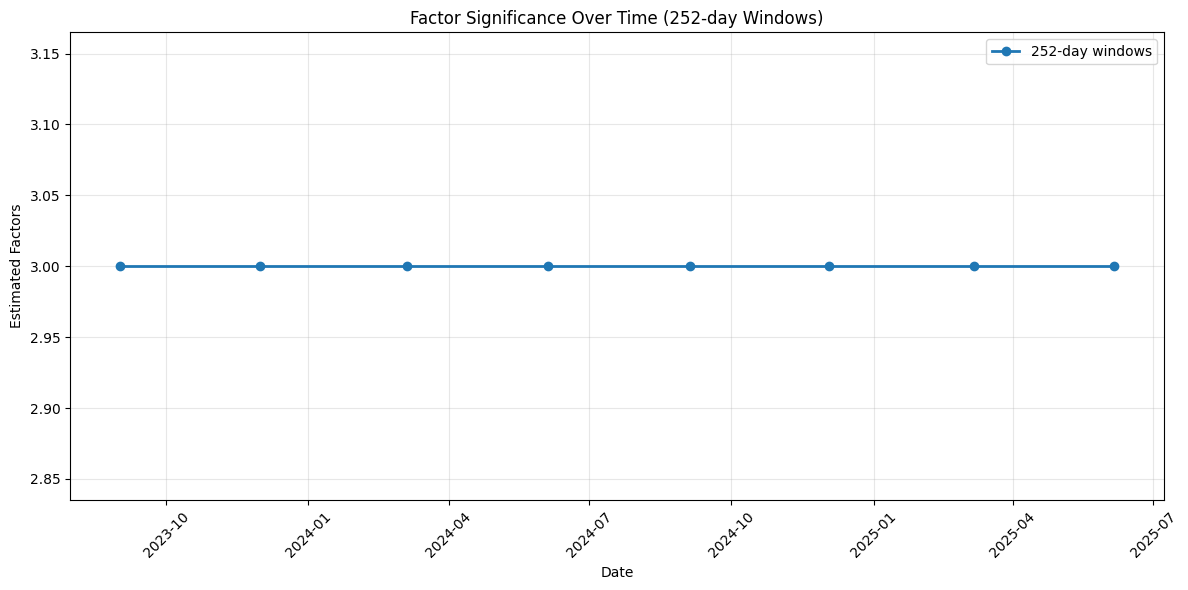


📋 252-DAY WINDOW RESULTS:


,Start Date,End Date,R Statistic,Estimated Factors
0,2022-09-01,2023-09-01,20.401131,3
1,2022-12-01,2023-12-01,100.958420,3
2,2023-03-06,2024-03-05,43.894003,3
3,2023-06-05,2024-06-04,43.105948,3
4,2023-09-05,2024-09-04,41.973024,3
5,2023-12-04,2024-12-03,47.436002,3
6,2024-03-06,2025-03-07,66.473939,3
7,2024-06-05,2025-06-06,67.381510,3


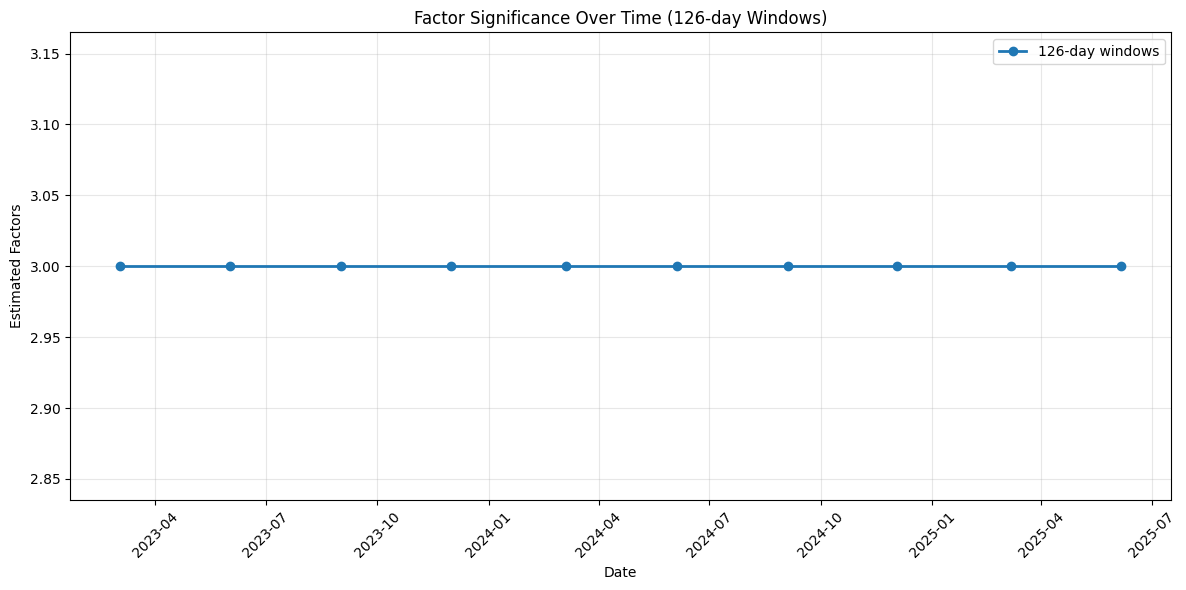


📋 126-DAY WINDOW RESULTS:


,Start Date,End Date,R Statistic,Estimated Factors
0,2022-09-01,2023-03-03,243.499579,3
1,2022-12-01,2023-06-02,65.414600,3
2,2023-03-06,2023-09-01,227.208442,3
3,2023-06-05,2023-12-01,294.628354,3
4,2023-09-05,2024-03-05,199.186950,3
5,2023-12-04,2024-06-04,53.646996,3
6,2024-03-06,2024-09-04,290.927934,3
7,2024-06-05,2024-12-03,435.552026,3
8,2024-09-05,2025-03-07,197.973091,3
9,2024-12-04,2025-06-06,61.149899,3



📈 DATA CHARACTERISTICS:
Total period: 2022-09-01 to 2025-08-29
Total trading days: 751
Assets: 32
Date range: 1093 days


In [46]:
def analyze_rolling_windows(returns_data, window_sizes=[252, 126], step_size=63):
    """
    Analyze factor significance using rolling windows
    window_sizes: 252 (1 year), 126 (6 months), 63 (3 months)
    step_size: 63 (1 quarter)
    """
    all_results = []
    
    for window_size in window_sizes:
        print(f"\n🔍 Analyzing {window_size}-day windows...")
        window_results = []
        
        for start_idx in range(0, len(returns_data) - window_size + 1, step_size):
            end_idx = start_idx + window_size
            window_data = returns_data.iloc[start_idx:end_idx]
            
            try:
                # Use a simplified version that works with smaller windows
                cov_matrix = window_data.cov()
                eigenvalues = eigh(cov_matrix, eigvals_only=True)
                eigenvalues = np.sort(eigenvalues)[::-1]
                
                # Calculate R statistic for k0=0 vs k1=3
                R_stat = onatski_test_statistic(eigenvalues, 0, 3)
                
                # Get critical value for k1-k0=3 (approximate)
                critical_vals = {0.01: 11.67, 0.05: 6.46, 0.10: 5.13}  # Approx values
                
                # Determine number of factors (simplified logic)
                estimated_factors = 0
                for alpha, crit_val in critical_vals.items():
                    if R_stat > crit_val:
                        estimated_factors = 3  # If R > critical, suggest multiple factors
                    else:
                        estimated_factors = 1  # If R <= critical, suggest market factor only
                        break
                
                window_results.append({
                    'Window Size': window_size,
                    'Start Date': returns_data.index[start_idx],
                    'End Date': returns_data.index[end_idx-1],
                    'Observations': len(window_data),
                    'R Statistic': R_stat,
                    'Estimated Factors': estimated_factors,
                    'First Eigenvalue': eigenvalues[0] if len(eigenvalues) > 0 else 0,
                    'Second Eigenvalue': eigenvalues[1] if len(eigenvalues) > 1 else 0
                })
                
            except Exception as e:
                continue
        
        if window_results:
            window_df = pd.DataFrame(window_results)
            all_results.append(window_df)
            print(f"✅ Completed {len(window_results)} windows of {window_size} days")
    
    return all_results

def analyze_halves(returns_data):
    """Analyze first half vs second half of your data"""
    mid_point = len(returns_data) // 2
    
    first_half = returns_data.iloc[:mid_point]
    second_half = returns_data.iloc[mid_point:]
    
    results = []
    
    for period, data in [('First Half', first_half), ('Second Half', second_half)]:
        try:
            results_df, _, _, _ = determine_factors_table(data, max_factors=3)
            results.append({
                'Period': period,
                'Start Date': data.index[0],
                'End Date': data.index[-1],
                'Observations': len(data),
                'R Statistic': results_df['R Statistic'].iloc[0],
                'Estimated Factors': results_df['Estimated Factors'].iloc[0]
            })
        except:
            results.append({
                'Period': period,
                'Start Date': data.index[0],
                'End Date': data.index[-1],
                'Observations': len(data),
                'R Statistic': np.nan,
                'Estimated Factors': 'Analysis Failed'
            })
    
    return pd.DataFrame(results)

# Run the rolling window analysis
print("🕐 ROLLING WINDOW ANALYSIS (Like the Paper)")
print("=" * 50)

# Analysis 1: First vs Second Half
print("\n📊 FIRST HALF vs SECOND HALF ANALYSIS")
halves_df = analyze_halves(returns_data)
display(halves_df)

# Analysis 2: Rolling windows
print("\n🔄 ROLLING WINDOW ANALYSIS")
window_dfs = analyze_rolling_windows(returns_data, window_sizes=[252, 126], step_size=63)

# Plot results
if window_dfs:
    for i, window_df in enumerate(window_dfs):
        window_size = window_df['Window Size'].iloc[0]
        
        plt.figure(figsize=(12, 6))
        plt.plot(window_df['End Date'], window_df['Estimated Factors'], 'o-', linewidth=2, label=f'{window_size}-day windows')
        plt.xlabel('Date')
        plt.ylabel('Estimated Factors')
        plt.title(f'Factor Significance Over Time ({window_size}-day Windows)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Display the rolling window results
        print(f"\n📋 {window_size}-DAY WINDOW RESULTS:")
        display(window_df[['Start Date', 'End Date', 'R Statistic', 'Estimated Factors']].head(10))

# Analysis 3: Pre-post specific events (if you have notable dates)
def analyze_event_periods(returns_data, event_dates):
    """Analyze periods around specific events"""
    event_results = []
    
    for event_name, event_date in event_dates.items():
        # Analyze 6 months before and after event
        before_start = event_date - pd.Timedelta(days=126)
        before_end = event_date - pd.Timedelta(days=1)
        after_start = event_date + pd.Timedelta(days=1)
        after_end = event_date + pd.Timedelta(days=126)
        
        # Filter data for these periods
        before_data = returns_data[(returns_data.index >= before_start) & (returns_data.index <= before_end)]
        after_data = returns_data[(returns_data.index >= after_start) & (returns_data.index <= after_end)]
        
        for period_name, period_data in [('Before', before_data), ('After', after_data)]:
            if len(period_data) > 100:
                try:
                    cov_matrix = period_data.cov()
                    eigenvalues = eigh(cov_matrix, eigvals_only=True)
                    eigenvalues = np.sort(eigenvalues)[::-1]
                    
                    R_stat = onatski_test_statistic(eigenvalues, 0, 3)
                    
                    event_results.append({
                        'Event': event_name,
                        'Period': period_name,
                        'Observations': len(period_data),
                        'R Statistic': R_stat,
                        'Market Dominance': eigenvalues[0] / np.sum(eigenvalues) if len(eigenvalues) > 0 else 0
                    })
                except:
                    continue
    
    return pd.DataFrame(event_results)

print(f"\n📈 DATA CHARACTERISTICS:")
print(f"Total period: {returns_data.index[0].strftime('%Y-%m-%d')} to {returns_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(returns_data)}")
print(f"Assets: {returns_data.shape[1]}")
print(f"Date range: {(returns_data.index[-1] - returns_data.index[0]).days} days")